<a href="https://colab.research.google.com/github/uervitonsantos/Otimizacao-Carteiras-Investimentos-Com-Rebalanceamentos/blob/feature%2FOtimizacaoCarteiras-01/Otimiza%C3%A7%C3%A3o_de_Carteiras_de_Investimentos_com_Rebalanceamentos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Aplica√ß√£o de Modelos de Confiabilidade e Metaheur√≠sticas na Otimiza√ß√£o de Carteiras de Investimentos com Rebalanceamentos relacionados ao risco**


**Objetivo**

O objetivo do trabalho √© desenvolver e validar uma metodologia para a otimiza√ß√£o de carteiras de investimento, com foco na identifica√ß√£o da necessidade e nos valores √≥timos dos rebalanceamentos dos ativos. A proposta envolve a modelagem da ocorr√™ncia de eventos de mercado que possam impactar significativamente os pre√ßos dos ativos, bem como notas de ag√™ncia de avalia√ß√£o. O estudo ser√° realizado utilizando Modelos de Sobreviv√™ncia baseados na Distribui√ß√£o de Weibull com Frailty, a fim de capturar riscos externos n√£o observ√°veis, como not√≠cias inesperadas e decis√µes governamentais. Os dados ser√£o extra√≠dos em 3 arquivos csv diferentes, o primeiro direto de uma base da B3, que ser√° o relat√≥rio consolidado da carteira de investimentos. O segundo ser√° extra√≠do da api da Brapi com os dados dos ativos. E o terceiro de alguma ag√™ncia de avalia√ß√£o (ainda em avalia√ß√£o).
Os par√¢metros dos modelos ser√£o estimados utilizando a fun√ß√£o de M√°xima Verossimilhan√ßa, garantindo o ajuste adequado aos dados hist√≥ricos das s√©ries de pre√ßos dos ativos. A partir da modelagem dos eventos, pretende-se determinar, por meio de Otimiza√ß√£o Bayesiana, os pontos √≥timos de rebalanceamento dos ativos da carteira, considerando informa√ß√µes como pre√ßo atual, pre√ßo m√©dio, n√∫mero de a√ß√µes, valor total investido em cada ativo e valor total investido na carteira. Os dados ser√£o extra√≠dos em um 3 arquivo csv direto de uma base da B3.
Al√©m disso, ser√° realizada a otimiza√ß√£o multiobjetiva da carteira empregando os algoritmos NSGA-II (Non-dominated Sorting Genetic Algorithm II) e MOPSO (Multi-Objective Particle Swarm Optimization), visando simultaneamente:
‚Ä¢	Maximizar o retorno esperado,
‚Ä¢	Minimizar o risco da carteira,
‚Ä¢	Minimizar os custos associados aos rebalanceamentos.
Por fim, ser√° conduzida uma an√°lise comparativa entre as abordagens propostas, com a avalia√ß√£o de m√©tricas de qualidade de solu√ß√µes multiobjetivas (como hipervolume, spread e IGD) e compara√ß√£o com estrat√©gias tradicionais de rebalanceamento peri√≥dico, buscando evidenciar as vantagens e limita√ß√µes da metodologia em cen√°rios pr√°ticos.

**Objetivo Espec√≠fico**

1.	Modelar a ocorr√™ncia de eventos de mercado que possam afetar significativamente os pre√ßos dos ativos, utilizando Modelos de Sobreviv√™ncia baseados na Distribui√ß√£o de Weibull com Frailty para capturar riscos n√£o observ√°veis.

2.	Utilizar Otimiza√ß√£o Bayesiana por meio da biblioteca Optuna para determinar os pesos √≥timos dos ativos na carteira, considerando o retorno esperado, risco e custos de rebalanceamento.

3.	Implementar a otimiza√ß√£o multiobjetiva da carteira utilizando os algoritmos NSGA-II (Non-dominated Sorting Genetic Algorithm II) e MOPSO (Multi-Objective Particle Swarm Optimization) para maximizar o retorno esperado, minimizar o risco da carteira e os custos associados aos rebalanceamentos.


4.	Realizar uma an√°lise comparativa entre as abordagens propostas (Otimiza√ß√£o Bayesiana com Optuna, NSGA-II e MOPSO), avaliando as solu√ß√µes geradas atrav√©s de m√©tricas de qualidade multiobjetiva, como hipervolume, spread e IGD, e comparando com estrat√©gias tradicionais de rebalanceamento peri√≥dico.


In [33]:
%%capture
!pip install lifelines -U pymoo seaborn optuna pytesseract opencv-python

In [34]:
import numpy as np
import pandas as pd
import optuna
import requests
import seaborn as sns
import cv2
import pytesseract
import re
import lifelines
from datetime import datetime
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from lifelines import KaplanMeierFitter
from lifelines import WeibullAFTFitter
from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.algorithms.moo.nsga3 import NSGA3
from pymoo.algorithms.moo.rnsga2 import RNSGA2
from pymoo.algorithms.moo.moead import MOEAD
from pymoo.termination import get_termination
from pymoo.util.ref_dirs import get_reference_directions
from pymoo.optimize import minimize
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.visualization.scatter import Scatter
from pymoo.core.problem import Problem
from pymoo.indicators.hv import HV
from google.colab.patches import cv2_imshow
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import gaussian_kde

In [35]:
# Variaveis utilizadas para acessar a api da brapi: https://brapi.dev/
token = 'wQsv3whghhynsSiXQj18Jm'
interval = '3mo'

Nesse ponto foi criado um arquivo com dados simulados. Porem, esses dados podem ser extraido da B3.

Para realizar a simula√ß√£o foi utilizado o codigo: https://github.com/uervitonsantos/simula-dados-carteira-investimentos/blob/main/Simula_dados_de_opera%C3%A7%C3%B5es_em_cateira_de_investimento.ipynb

Link para acesso ao Dataset: https://drive.google.com/file/d/1-15NzorUCz7iS8TuuATr6ADaOYdbOlOF/view?usp=drive_link

In [36]:
df = pd.read_csv(f'/content/drive/MyDrive/datasets/dados-acoes/carteira-de-ativos.csv', sep=",")
df.head(3)

Entrada/Sa√≠da        Data            Produto  Quantidade Pre√ßo unit√°rio  \
0        Compra  10/06/2025  VALE3 - VALE S.A.         200    R$ 4.221,54   
1        Compra  07/06/2025  VALE3 - VALE S.A.         100    R$ 2.159,74   
2        Compra  30/05/2025  VALE3 - VALE S.A.         100    R$ 2.766,14   

  Valor da Opera√ß√£o  
0     R$ 844.308,00  
1     R$ 215.974,00  
2     R$ 276.614,00

# **Pr√©-processamento e Organiza√ß√£o dos Dados Operacionais**

Nesta etapa, foi realizado o pr√©-processamento dos dados provenientes de opera√ß√µes financeiras, com o objetivo de estrutur√°-los adequadamente para an√°lise. Inicialmente, a coluna correspondente √†s datas das opera√ß√µes foi convertida para o tipo datetime, utilizando o par√¢metro dayfirst=True para considerar o formato de data com o dia precedendo o m√™s, padr√£o comum no Brasil. Em seguida, realizou-se a padroniza√ß√£o da coluna referente aos produtos negociados, por meio da aplica√ß√£o de uma express√£o regular que extrai exclusivamente o c√≥digo do ativo (ticker), tipicamente formado por quatro letras seguidas de um n√∫mero, como PETR4 ou VALE3.

A partir desses c√≥digos, foi criada uma nova coluna chamada "Ticker", que isola o identificador do ativo, removendo poss√≠veis descri√ß√µes adicionais que pudessem estar presentes. Para caracterizar o tipo de opera√ß√£o, a coluna "Entrada/Sa√≠da" foi mapeada para valores num√©ricos, atribuindo 1 √†s opera√ß√µes de compra (indicando entrada do ativo na carteira) e 0 √†s de venda (representando a sa√≠da do ativo).

Com o intuito de calcular o tempo decorrido desde cada opera√ß√£o at√© a data de refer√™ncia da an√°lise, foi criada a vari√°vel "Tempo", obtida pela diferen√ßa entre a data atual do sistema e a data da opera√ß√£o. Para evitar valores nulos ou negativos, somou-se uma unidade ao resultado e aplicou-se um limite inferior m√≠nimo de 0.1, garantindo valores positivos em formato de ponto flutuante.

Adicionalmente, os valores monet√°rios presentes nas colunas "Valor da Opera√ß√£o" e "Pre√ßo unit√°rio" foram tratados para remover formata√ß√µes espec√≠ficas do sistema financeiro brasileiro, como o s√≠mbolo de real (R$), os separadores de milhar (.) e a v√≠rgula decimal (,) que foram convertidos para o padr√£o num√©rico utilizado no ambiente de programa√ß√£o. Ap√≥s essas transforma√ß√µes, os campos foram convertidos para o tipo float.

Por fim, com vistas √† obten√ß√£o de uma s√©rie hist√≥rica representativa, os dados foram agrupados por data e ticker, e o pre√ßo m√©dio unit√°rio foi calculado para cada ativo em cada data, utilizando a fun√ß√£o de m√©dia (mean). Esse agrupamento foi reestruturado com a fun√ß√£o unstack, resultando em uma tabela bidimensional onde as colunas representam os diferentes ativos e as linhas representam as datas, com os respectivos pre√ßos m√©dios hist√≥ricos.

In [37]:
df['Data'] = pd.to_datetime(df['Data'], dayfirst=True)
df['Produto'] = df['Produto'].str.extract(r'(\w{4}\d)').squeeze()  # extrai CSAN3, KLBN4, etc.

# Extrai o ticker antes do ' - '
df['Ticker'] = df['Produto'].apply(lambda x: str(x).split(' - ')[0].strip())

# Evento: Compra = 1 (ativo entrou na carteira), Venda = 0 (saiu)
df['Evento'] = df['Entrada/Sa√≠da'].map({'Compra': 1, 'Venda': 0})

# Tempo: diferen√ßa entre a data da opera√ß√£o e uma refer√™ncia (hoje ou √∫ltima data da venda)
data_referencia = pd.to_datetime(datetime.today().date())  # data atual do sistema (a "data de hoje")
df['Tempo'] = (data_referencia - df['Data']).dt.days + 1  # +1 para evitar zero
df['Tempo'] = df['Tempo'].clip(lower=0.1).astype(float)  # Garante que 'Tempo' est√° positivo e em float

# Corrigir valores num√©ricos
df['Valor da Opera√ß√£o'] = df['Valor da Opera√ß√£o'].replace({'R\$': '', '\.': '', ',': '.'}, regex=True).astype(float)
df['Pre√ßo unit√°rio'] = df['Pre√ßo unit√°rio'].replace({'R\$': '', '\.': '', ',': '.'}, regex=True).astype(float)

# Agrupa por data e ticker e calcula pre√ßo m√©dio (pode ser o unit√°rio da compra/venda)
precos_historicos = df.groupby(['Data', 'Ticker'])['Pre√ßo unit√°rio'].mean().unstack()

# **C√°lculo do Tempo Mediano de Perman√™ncia dos Ativos na Carteira**

Com o objetivo de analisar a din√¢mica de perman√™ncia dos ativos na carteira ao longo do tempo, foi desenvolvido um procedimento para estimar, por ativo (ticker), o tempo mediano entre a data de compra e a data correspondente de venda. Inicialmente, os dados foram agrupados pela vari√°vel "Ticker", de modo que cada grupo representasse o hist√≥rico completo de opera√ß√µes de um determinado ativo.

Para cada ativo, foram separadas as listas de datas de compra (opera√ß√µes marcadas com valor 1 na coluna "Evento") e de venda (opera√ß√µes com valor 0). As listas foram ordenadas cronologicamente para garantir que os emparelhamentos fossem realizados na ordem temporal correta. Em seguida, utilizou-se a fun√ß√£o zip para emparelhar cada data de compra com a correspondente data de venda subsequente, assumindo que as opera√ß√µes seguem uma l√≥gica FIFO (First-In, First-Out). Apenas pares com venda posterior √† compra foram considerados v√°lidos para o c√°lculo.

Para cada par v√°lido (compra, venda), foi calculado o n√∫mero de dias decorridos entre as duas datas. A partir da lista de intervalos obtida para cada ativo, foi ent√£o calculada a mediana do tempo de perman√™ncia, de forma a obter uma medida robusta em rela√ß√£o a valores extremos ou outliers. Essa informa√ß√£o foi armazenada em um dicion√°rio, onde as chaves representam os tickers e os valores correspondem ao tempo mediano de perman√™ncia, em dias.

O resultado final constitui uma estrutura de dados que associa, de maneira eficiente, cada ativo ao seu tempo t√≠pico de reten√ß√£o na carteira, podendo ser utilizada posteriormente em an√°lises de perfil de negocia√ß√£o, constru√ß√£o de estrat√©gias ou avalia√ß√£o de liquidez.

In [38]:
tempos_por_ticker = {}

for ticker, grupo in df.groupby('Ticker'):
    compras = grupo[grupo['Evento'] == 1].sort_values('Data')['Data'].tolist()
    vendas = grupo[grupo['Evento'] == 0].sort_values('Data')['Data'].tolist()

    pares = zip(compras, vendas)  # Emparelha na ordem
    tempos = [(venda - compra).days for compra, venda in pares if venda > compra]

    if tempos:
        tempos_por_ticker[ticker] = np.median(tempos)

# Resultado: dicion√°rio {ticker: tempo_medio_em_dias}
tempo_medianos = tempos_por_ticker

In [39]:
df_surv = df[['Produto', 'Tempo', 'Evento']]
tickers = df['Ticker'].unique()

Para compor uma an√°lise fundamentalista e t√©cnica dos ativos listados em carteira, foi implementado um procedimento automatizado de extra√ß√£o de dados financeiros e de mercado por meio da API p√∫blica Brapi.dev: https://brapi.dev/. A etapa em quest√£o tem como finalidade consultar, para cada ticker (ativo), um conjunto de informa√ß√µes relevantes ao investimento, incluindo pre√ßo atual, indicadores fundamentais e varia√ß√µes recentes.

Inicialmente, foi criada uma lista vazia denominada dados_ativos, destinada a armazenar os resultados das consultas realizadas. Em seguida, um la√ßo de repeti√ß√£o (for) percorre a lista de tickers previamente definida, e, para cada ativo, √© constru√≠da uma URL personalizada contendo par√¢metros como intervalo de tempo (range), frequ√™ncia das cota√ß√µes (interval=1d), e os m√≥dulos desejados, como summaryProfile e fundamental.

A URL √© ent√£o requisitada via m√©todo GET utilizando a biblioteca requests. Caso a resposta da API apresente status de sucesso (200), os dados retornados s√£o processados no formato JSON. Dentre as informa√ß√µes extra√≠das, est√° o pre√ßo atual de mercado (regularMarketPrice) e o hist√≥rico di√°rio de pre√ßos de fechamento, contido no campo historicalDataPrice. A partir desses pre√ßos de fechamento, calcula-se a m√©dia do per√≠odo e, em seguida, a varia√ß√£o percentual entre o pre√ßo atual e essa m√©dia, servindo como um indicador t√©cnico de desvio.

Al√©m disso, o c√≥digo acessa dados fundamentais como o setor da empresa, o pre√ßo m√≠nimo e m√°ximo nas √∫ltimas 52 semanas, o √≠ndice Pre√ßo/Lucro (P/L), o Dividend Yield (DY), o Return on Equity (ROE), o Pre√ßo sobre Valor Patrimonial (P/VP) e o volume m√©dio de negocia√ß√£o dos √∫ltimos tr√™s meses. Todos esses dados s√£o armazenados como dicion√°rios dentro da lista dados_ativos, permitindo posterior an√°lise, visualiza√ß√£o ou persist√™ncia em banco de dados.

Caso a requisi√ß√£o para algum ticker falhe, o sistema emite um alerta na sa√≠da padr√£o, indicando o c√≥digo de erro HTTP correspondente. Esse tratamento garante maior robustez ao processo de coleta autom√°tica. Em conjunto, essa etapa fornece uma base s√≥lida para an√°lises quantitativas e qualitativas de cada ativo em carteira.

In [40]:
dados_ativos = []  # dicion√°rio para guardar os dados vindos da https://brapi.dev

# Loop para consultar cada ticker
for ticker in tickers:
    url = f'https://brapi.dev/api/quote/{ticker}?range={interval}&interval=1d&fundamental=true&modules=summaryProfile&token={token}'
    response = requests.get(url)

    if response.status_code == 200:
        data = response.json()
        print(f"{ticker}: OK")
        result = data['results'][0]

        preco_atual = result.get('regularMarketPrice')
        # Calcular a m√©dia dos fechamentos com base no intervalo, em dias, configurado na url
        historico = result.get('historicalDataPrice', [])
        precos_fechamento = [dia.get('close') for dia in historico if dia.get('close') is not None]

        if precos_fechamento:
            media_dias = sum(precos_fechamento) / len(precos_fechamento)
            variacao_pct = (preco_atual - media_dias) / media_dias if preco_atual else None
        else:
            media_dias = None
            variacao_pct = None

        dados_ativos.append({
            'Ticker': ticker,
            'Empresa': result.get('shortName'),
            'Setor': result.get('summaryProfile', {}).get('sector'),
            'Pre√ßo Atual': preco_atual,
            'M√©dia em Dias': media_dias,
            'Varia√ß√£o % M√©dia em Dias': variacao_pct,
            'Min 52 Semanas': result.get('fiftyTwoWeekLow'),
            'Max 52 Semanas': result.get('fiftyTwoWeekHigh')
        })

    else:
        print(f"{ticker}: ERRO - {response.status_code}")

VALE3: OK
ITUB4: OK
PETR4: OK
BBAS3: OK
CXSE3: OK


In [41]:
# Converter para DataFrame
df_api = pd.DataFrame(dados_ativos)
# Salvar em CSV
df_api.to_csv('/content/drive/MyDrive/datasets/dados-acoes/ativos_brapi.csv', index=False)
print("\n‚úÖ Dados salvos em 'ativos_brapi.csv'.")


‚úÖ Dados salvos em 'ativos_brapi.csv'.


In [42]:
df_api = pd.read_csv('/content/drive/MyDrive/datasets/dados-acoes/ativos_brapi.csv')
df_api.head(3)

Ticker                 Empresa               Setor  Pre√ßo Atual  \
0  VALE3  VALE        ON      NM     Basic Materials        52.13   
1  ITUB4  ITAUUNIBANCOPN  EJ  N1  Financial Services        36.17   
2  PETR4  PETROBRAS   PN  EDJ N2              Energy        32.53   

   M√©dia em Dias  Varia√ß√£o % M√©dia em Dias  Min 52 Semanas  Max 52 Semanas  
0      54.333607                 -0.040557          48.770           65.35  
1      34.684874                  0.042818          27.109           38.62  
2      32.430161                  0.003079          28.860           40.76

Este script Python realiza uma an√°lise fundamentalista de a√ß√µes da B3 utilizando os dados do site Fundamentus. O objetivo √© pontuar e ranquear a√ß√µes com base em crit√©rios quantitativos de qualidade e valuation.


In [43]:
df_fund = pd.read_csv('/content/drive/MyDrive/datasets/dados-acoes/pontuacao-dados-fundamentalistas.csv', sep=";")
df_fund.head()

A√ß√£o  Pontua√ß√£o
0  VALE3      83.33
1  PETR4      83.33
2  BBAS3      75.00
3  ITUB4      66.67
4  CXSE3      66.67

# **C√°lculo do Fator de Frailty com Base na Varia√ß√£o Percentual de Pre√ßo**

Com o intuito de incorporar um elemento de heterogeneidade no modelo de sobreviv√™ncia aplicado aos ativos financeiros, foi desenvolvido um procedimento para estimar o chamado fator de frailty (fragilidade) a partir da varia√ß√£o percentual entre o pre√ßo atual e a m√©dia dos pre√ßos de fechamento ao longo de um determinado intervalo de tempo. A no√ß√£o de frailty √© frequentemente utilizada em modelos de an√°lise de sobreviv√™ncia para representar fatores n√£o observ√°veis que afetam o risco de um evento ocorrer ‚Äî neste caso, a venda de um ativo.

Inicialmente, foi criado um dicion√°rio chamado frailty_fatores, respons√°vel por associar cada ativo ao seu respectivo fator de frailty. Para cada item contido na lista dados_ativos (previamente obtida por meio da API Brapi.dev), extraiu-se a varia√ß√£o percentual entre o pre√ßo atual e a m√©dia dos pre√ßos anteriores. Este valor foi ent√£o ajustado para formar um fator multiplicativo segundo a f√≥rmula: frailty = 1 + varia√ß√£o, com arredondamento para duas casas decimais. Caso o dado de varia√ß√£o estivesse ausente (None), foi atribu√≠do o valor neutro de 1.0, indicando aus√™ncia de fragilidade adicional.

Na sequ√™ncia, foi constru√≠da uma lista contendo apenas os tickers com dados v√°lidos, assegurando que apenas ativos com informa√ß√µes completas fossem considerados nas etapas subsequentes da an√°lise. O fator de frailty foi ent√£o incorporado ao DataFrame principal df, por meio do m√©todo map, associando os tickers do conjunto de eventos ao valor de frailty calculado. Para tickers ausentes no dicion√°rio, o valor padr√£o de 1.0 foi novamente utilizado.

Por fim, foi gerado um novo DataFrame denominado df_eventos, contendo as colunas essenciais para an√°lise de sobreviv√™ncia: o ativo (Ativo), o tempo at√© o evento (Tempo), o tipo de evento (Evento, onde 1 representa compra e 0 representa venda), e o fator de frailty. Este conjunto de dados, enriquecido com o elemento de heterogeneidade n√£o observ√°vel, est√° pronto para ser utilizado em modelos estat√≠sticos como o de Cox proporcional com frailty ou modelos param√©tricos com efeitos aleat√≥rios, contribuindo para uma representa√ß√£o mais realista dos riscos de sa√≠da dos ativos da carteira.

In [44]:
# -------------------------------------------
# 1. CALCULA FRAILTY BASEADO NA VARIA√á√ÉO
# -------------------------------------------

# Cria dicion√°rio: {'VALE3': 83.33, ...}
pontuacoes_fundamentalistas = df_fund.set_index('A√ß√£o')['Pontua√ß√£o'].to_dict()

# Fator de ajuste da influ√™ncia da pontua√ß√£o (ex: 0.5 significa at√© 50% de desconto na frailty)
ajuste_fundamentalista = 0.5
penalizacao_extra = 1.6  # penalizar frailty em 60% extra se pontua√ß√£o < 70

# Calcula frailty combinada
frailty_fatores = {}
for dados in dados_ativos:
    ticker = dados['Ticker']
    variacao = dados.get('Varia√ß√£o % M√©dia em Dias')
    pontuacao = pontuacoes_fundamentalistas.get(ticker, 50.0)  # padr√£o 50.0 se n√£o encontrado

    if variacao is not None and pontuacao is not None:
        # Frailty ajustada pela pontua√ß√£o
        frailty = (1 + variacao) * (1 - (pontuacao / 100) * ajuste_fundamentalista)

        # Penaliza√ß√£o adicional se pontua√ß√£o < 70
        if pontuacao < 70.0:
            frailty *= penalizacao_extra
    else:
        frailty = 1.0  # valor neutro

    frailty_fatores[ticker] = frailty

# Aqui usamos apenas os tickers com dados v√°lidos
ativos = [dado['Ticker'] for dado in dados_ativos]

# Aplica a frailty no DataFrame real
df['Frailty'] = df['Ticker'].map(frailty_fatores).fillna(1.0)

# Cria DataFrame final de eventos
df_eventos = df[['Ticker', 'Tempo', 'Evento', 'Frailty']].copy()
df_eventos = df_eventos.rename(columns={'Ticker': 'Ativo'})
print(df_eventos.head(600))

     Ativo  Tempo  Evento   Frailty
0    VALE3    4.0       1  0.559691
1    VALE3    7.0       1  0.559691
2    VALE3   15.0       1  0.559691
3    VALE3   18.0       0  0.559691
4    VALE3   18.0       0  0.559691
..     ...    ...     ...       ...
527  CXSE3  345.0       0  1.017294
528  CXSE3  345.0       0  1.017294
529  CXSE3  349.0       1  1.017294
530  CXSE3  356.0       1  1.017294
531  CXSE3  362.0       0  1.017294

[532 rows x 4 columns]


# **Ajuste do Modelo Weibull AFT com Frailty via Vari√°veis Dummies**

Com o objetivo de modelar o tempo de perman√™ncia dos ativos na carteira sob a √≥tica da an√°lise de sobreviv√™ncia, foi utilizado o modelo AFT (Accelerated Failure Time) com distribui√ß√£o de Weibull. O modelo AFT √© uma alternativa ao modelo de riscos proporcionais de Cox, sendo particularmente adequado quando se deseja interpretar diretamente o efeito das covari√°veis sobre o tempo at√© a ocorr√™ncia do evento. Neste contexto, o evento de interesse √© a venda do ativo, e o tempo √© o n√∫mero de dias entre a compra e a venda.

Para capturar os efeitos espec√≠ficos de cada ativo sobre o tempo de sobreviv√™ncia, foram utilizadas vari√°veis dummies (indicadoras), geradas a partir da coluna "Ativo". Esse processo foi implementado com a fun√ß√£o pd.get_dummies(), que converte a vari√°vel categ√≥rica "Ativo" em um conjunto de colunas bin√°rias, cada uma representando a presen√ßa (valor 1) ou aus√™ncia (valor 0) de um determinado ativo. Importante destacar que o par√¢metro drop_first=False foi especificado para evitar a omiss√£o de qualquer ativo do modelo ‚Äî uma escolha apropriada neste caso, dado o interesse em estimar os efeitos absolutos e n√£o apenas relativos entre categorias.

Al√©m das vari√°veis indicadoras dos ativos, a coluna "Frailty", calculada na etapa anterior, foi mantida como uma covari√°vel cont√≠nua no modelo. Essa inclus√£o permite capturar a heterogeneidade n√£o observada entre ativos, agregando robustez √† estimativa dos tempos de perman√™ncia.

Com a estrutura do DataFrame df_model devidamente preparada, foi utilizado o estimador WeibullAFTFitter() da biblioteca lifelines para ajustar o modelo. O m√©todo fit() foi aplicado especificando as colunas duration_col='Tempo' e event_col='Evento', o que define, respectivamente, a vari√°vel de tempo e a vari√°vel indicadora do evento no modelo de sobreviv√™ncia.

O modelo resultante permite avaliar, para cada ativo e dado seu fator de frailty, o efeito sobre o tempo de reten√ß√£o na carteira, fornecendo subs√≠dios para interpreta√ß√µes associadas ao comportamento t√≠pico dos investidores frente a diferentes ativos. Esse tipo de an√°lise √© particularmente relevante para estrat√©gias baseadas em tempo de investimento, liquidez e rotatividade da carteira.

In [45]:
# -----------------------------
# 2. AJUSTE DO MODELO WEIBULL AFT COM FRAILTY VIA DUMMIES
# -----------------------------
%%capture
df_model = pd.get_dummies(df_eventos[['Tempo', 'Evento', 'Ativo', 'Frailty']], columns=['Ativo'], drop_first=False)
aft = WeibullAFTFitter()
aft.fit(df_model, duration_col='Tempo', event_col='Evento')

O presente modelo de sobreviv√™ncia foi constru√≠do para estimar o tempo at√© a ocorr√™ncia de um evento de compra (entrada) de um ativo na carteira, utilizando o modelo *Weibull AFT (Accelerated Failure Time*) com ajuste de *frailty* para capturar heterogeneidades entre os ativos. No contexto deste estudo, o evento bin√°rio √© definido como "**Compra**" (1), representando a entrada do ativo na carteira, enquanto "**Venda**" (0) indica que o evento ainda n√£o ocorreu (censura). Dessa forma, as curvas de sobreviv√™ncia estimadas representam a probabilidade de o ativo ainda n√£o ter sido comprado conforme o tempo passa. Ativos com curvas que decaem mais rapidamente indicam maior propens√£o a serem comprados em menor tempo ‚Äî ou seja, com maior probabilidade de participa√ß√£o ativa na carteira ao longo do tempo. Considerando a natureza c√≠clica das opera√ß√µes (compra e venda), este processo tamb√©m pode ser interpretado como **uma modelagem do tempo at√© o pr√≥ximo rebalanciamento do ativo na carteira**.


* Quando a curva cai abaixo de 0.5, significa que mais da metade dos casos j√° sofreram o evento.

* O ponto em que a curva cruza 0.5 √© chamado de tempo mediano de sobreviv√™ncia.

Ele √© √∫til para comparar ativos: quanto maior esse tempo, mais tempo o ativo costuma permanecer na carteira sem ser rebalanceado.

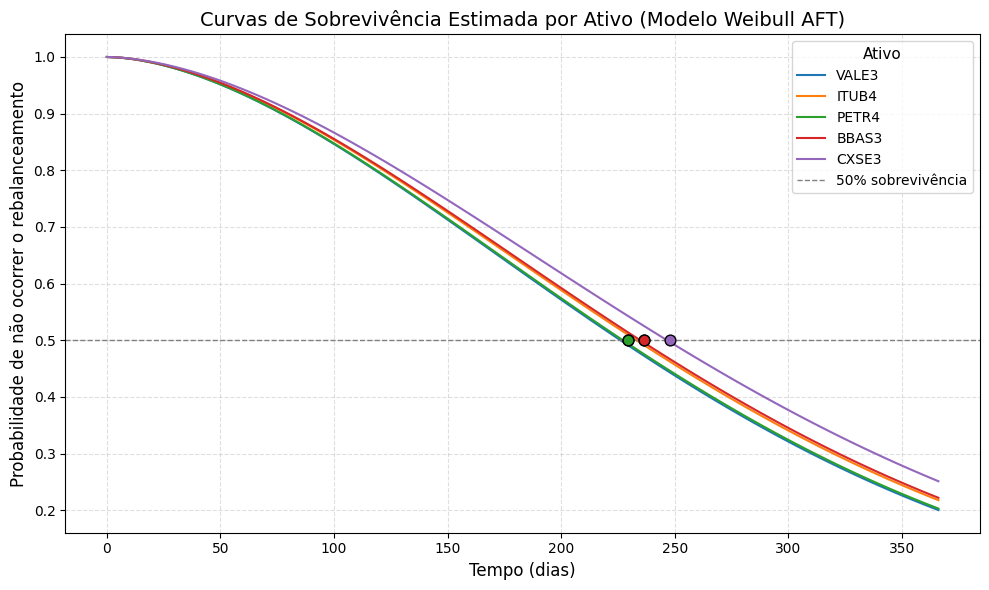

In [46]:
# -----------------------------------
# 3. PLOTAR CURVAS DE SOBREVIV√äNCIA
# ----------------------------------
# Cria figura e eixos
fig, ax = plt.subplots(figsize=(10, 6))

# Paleta de cores para distinguir os ativos
cores = sns.color_palette("tab10", n_colors=len(ativos))

# Plota curvas de sobreviv√™ncia por ativo
for i, ativo in enumerate(ativos):
    # Cria amostra com zeros e ativa a dummy correspondente (se existir)
    amostra = pd.DataFrame([0] * (len(df_model.columns) - 2), index=df_model.columns.drop(['Tempo', 'Evento'])).T
    col_dummy = f'Ativo_{ativo}'
    if col_dummy in amostra.columns:
        amostra[col_dummy] = 1

    # Gera curva de sobreviv√™ncia para o ativo
    surv_func = aft.predict_survival_function(amostra, times=np.linspace(0.1, df_eventos['Tempo'].max(), 100))

    # Plota curva
    ax.plot(surv_func.index, surv_func.values.flatten(), label=ativo, color=cores[i])

    # Marca a mediana de sobreviv√™ncia (tempo onde a curva cruza 0.5)
    y = surv_func.values.flatten()
    x = surv_func.index
    cruzamento = np.where(y <= 0.5)[0]
    if cruzamento.any():
        tempo_mediano = x[cruzamento[0]]
        ax.scatter(tempo_mediano, 0.5, color=cores[i], s=60, marker='o', edgecolor='black', zorder=5)

# Linha horizontal indicando 50% de sobreviv√™ncia
ax.axhline(0.5, color='gray', linestyle='--', linewidth=1, label='50% sobreviv√™ncia')

# T√≠tulos e r√≥tulos
ax.set_title('Curvas de Sobreviv√™ncia Estimada por Ativo (Modelo Weibull AFT)', fontsize=14)
ax.set_xlabel('Tempo (dias)', fontsize=12)
ax.set_ylabel('Probabilidade de n√£o ocorrer o rebalanceamento', fontsize=12)

# Legenda lateral
ax.legend(title="Ativo", fontsize=10, title_fontsize=11)

# Est√©tica
ax.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

# **Pr√©-c√°lculos para a Etapa de Otimiza√ß√£o Bayesiana com Optuna**

Antes da execu√ß√£o da etapa de otimiza√ß√£o propriamente dita, foram realizados pr√©-c√°lculos essenciais para alimentar a fun√ß√£o objetivo utilizada na etapa 4, onde se aplica a otimiza√ß√£o bayesiana com o pacote Optuna. Essa prepara√ß√£o envolve o c√°lculo de m√©tricas fundamentais associadas ao desempenho dos ativos financeiros: retorno e risco.

Primeiramente, os retornos di√°rios dos ativos foram obtidos a partir do hist√≥rico de pre√ßos (precos_historicos), utilizando a fun√ß√£o pct_change() do pandas, que calcula a varia√ß√£o percentual entre dias consecutivos. A fun√ß√£o dropna() √© aplicada em seguida para eliminar a primeira linha resultante com valor nulo, consequ√™ncia do c√°lculo de diferen√ßa percentual.

In [47]:
#--------------------------------------------------------------------------
# PR√â-C√ÅLCULOS PARA A FUN√á√ÉO NA 4 ETAPA DE OTIMIZA√á√ÉO BAYESIANA COM OPTUNA
#--------------------------------------------------------------------------
retornos_diarios = precos_historicos.pct_change().dropna() # calcule os retornos di√°rios
retornos_ativos = retornos_diarios.mean().to_dict()  # retorno m√©dio por ativo
riscos_ativos = retornos_diarios.std().to_dict()     # desvio padr√£o por ativo (risco)

Nesse ponto tentamos responder √† seguinte pergunta:

***‚ÄúQual seria a melhor aloca√ß√£o percentual nos ativos para maximizar retorno, minimizar risco e evitar rebalanceamentos caros?‚Äù***

Este trecho de c√≥digo realiza a otimiza√ß√£o dos pesos dos ativos da carteira utilizando a t√©cnica de Otimiza√ß√£o Bayesiana com a biblioteca Optuna. O objetivo principal √© encontrar a aloca√ß√£o ideal dos ativos ‚Äî ou seja, os percentuais que cada ativo deve representar na carteira ‚Äî de forma que o retorno esperado seja maximizado, enquanto o risco total e os custos de rebalanceamento sejam minimizados.

Primeiramente, s√£o calculados os retornos e riscos reais de cada ativo com base nos pre√ßos hist√≥ricos: o retorno √© obtido pela m√©dia dos retornos di√°rios e o risco pelo desvio padr√£o desses retornos. Tamb√©m √© utilizado o tempo mediano de perman√™ncia de cada ativo na carteira (calculado anteriormente) como uma forma de penalizar ativos que exigem rebalanceamento muito frequente.

A fun√ß√£o objetivo da otimiza√ß√£o recebe os pesos sugeridos para os ativos, normaliza esses pesos, e ent√£o calcula:

* o retorno esperado da carteira (m√©dia ponderada dos retornos),

* o risco total da carteira (m√©dia ponderada dos desvios padr√£o),

* e um custo de rebalanceamento proporcional √† frequ√™ncia com que os ativos s√£o comprados ou vendidos.

Esses tr√™s fatores s√£o combinados em uma m√©trica √∫nica chamada "score", que √© o valor a ser minimizado durante o processo de otimiza√ß√£o. Ao final, o Optuna retorna a melhor combina√ß√£o de pesos encontrada, representando a composi√ß√£o √≥tima da carteira segundo os crit√©rios definidos.

In [48]:
# -----------------------------------
# 4. OTIMIZA√á√ÉO BAYESIANA COM OPTUNA
# -----------------------------------

def funcao_objetivo(trial):
    peso_ativos = np.array([trial.suggest_float(f"peso_{i}", 0.0, 1.0) for i in range(len(ativos))])
    peso_ativos /= peso_ativos.sum()

    retornos = np.array([retornos_ativos.get(ativo, 0.0) for ativo in ativos])
    riscos = np.array([riscos_ativos.get(ativo, 0.1) for ativo in ativos])
    rebal_freq = np.array([1 / tempo_medianos.get(ativo, 30.0) for ativo in ativos])

    retorno_esperado = np.dot(peso_ativos, retornos)
    risco_total = np.dot(peso_ativos, riscos)
    custo_rebalanceamento = np.dot(peso_ativos, rebal_freq) * 0.01

    score = retorno_esperado - risco_total - custo_rebalanceamento
    return -score

study = optuna.create_study(direction="minimize")
study.optimize(funcao_objetivo, n_trials=100)

print("\nMelhores pesos encontrados pela Otimiza√ß√£o Bayesiana (Optuna):")
for i, ativo in enumerate(ativos):
    print(f"{ativo}: {study.best_params[f'peso_{i}']:.4f}")
print("Score final:", -study.best_value)

[I 2025-06-13 21:40:34,119] A new study created in memory with name: no-name-22c4a5ba-9e3d-484d-bca8-9b42d0d44d0a
[I 2025-06-13 21:40:34,125] Trial 0 finished with value: 0.5150557592513431 and parameters: {'peso_0': 0.8955337958820527, 'peso_1': 0.8566021913064266, 'peso_2': 0.9058830152898278, 'peso_3': 0.824394149973299, 'peso_4': 0.5471814812418484}. Best is trial 0 with value: 0.5150557592513431.
[I 2025-06-13 21:40:34,128] Trial 1 finished with value: 0.9388024470480152 and parameters: {'peso_0': 0.8092098093659454, 'peso_1': 0.13794377574055572, 'peso_2': 0.33218279422361285, 'peso_3': 0.020202384178176325, 'peso_4': 0.5331443133101892}. Best is trial 0 with value: 0.5150557592513431.
[I 2025-06-13 21:40:34,130] Trial 2 finished with value: 0.2526727004339371 and parameters: {'peso_0': 0.2297108506342277, 'peso_1': 0.5815928060476497, 'peso_2': 0.8646656577933459, 'peso_3': 0.519851669322601, 'peso_4': 0.37879000834415855}. Best is trial 2 with value: 0.2526727004339371.
[I 2025


Melhores pesos encontrados pela Otimiza√ß√£o Bayesiana (Optuna):
VALE3: 0.0005
ITUB4: 0.0764
PETR4: 0.2170
BBAS3: 0.2273
CXSE3: 0.9339
Score final: -0.05588935467399275


In [49]:
# Converte os dicion√°rios para arrays na mesma ordem de 'ativos'
retorno_ativos_array = np.array([retornos_ativos[ativo] for ativo in ativos])
risco_ativos_array = np.array([riscos_ativos[ativo] for ativo in ativos])
rebal_freq_array = np.array([1 / tempo_medianos[ativo] for ativo in ativos])  # frequ√™ncia ‚âà 1 / tempo mediano

# **Otimiza√ß√£o Multiobjetivo com NSGA-II e MOPSO (via PyMoo)**

Nesta etapa do trabalho, foi implementado um modelo de otimiza√ß√£o multiobjetivo com o uso do pacote pymoo, visando a constru√ß√£o de carteiras de investimento eficientes sob m√∫ltiplos crit√©rios simult√¢neos. O modelo considera tr√™s objetivos principais: maximizar o retorno esperado, minimizar o risco (medido pelo desvio padr√£o dos retornos) e minimizar o custo de rebalanceamento da carteira. Para isso, foi definida uma classe personalizada (CarteiraMultiObjetivo) que representa formalmente o problema de otimiza√ß√£o a ser resolvido por algoritmos evolutivos como NSGA-II e MOPSO.

Cada carteira √© representada por um vetor de pesos, em que cada valor corresponde √† propor√ß√£o de capital alocada em um ativo. A fun√ß√£o de avalia√ß√£o calcula o retorno como o somat√≥rio ponderado dos retornos m√©dios dos ativos, o risco como a soma ponderada das volatilidades individuais e o custo de rebalanceamento como uma penalidade proporcional √† frequ√™ncia com que os ativos s√£o ajustados na carteira. Como o pymoo realiza minimiza√ß√µes por padr√£o, o retorno √© invertido (multiplicado por -1) para que seu valor m√°ximo represente a melhor solu√ß√£o. Al√©m disso, √© imposta uma restri√ß√£o que obriga a soma dos pesos a ser igual a 1, garantindo que 100% do capital esteja alocado.

Essa modelagem permite explorar a fronteira de Pareto, onde nenhuma solu√ß√£o √© superior a outra em todos os crit√©rios ao mesmo tempo. Assim, o investidor pode tomar decis√µes mais informadas com base em seu perfil de risco e prefer√™ncias em rela√ß√£o a custo e retorno.





In [50]:
# -----------------------------
# 5. OTIMIZA√á√ÉO MULTIOBJETIVO COM NSGA-II E MOPSO (via pymoo)
# -----------------------------

# Define o problema de otimiza√ß√£o multiobjetivo
class CarteiraMultiObjetivo(Problem):
    def __init__(self):
        super().__init__(
            n_var=len(ativos),   # n√∫mero de ativos
            n_obj=3,             # retorno, risco e custo
            n_constr=1,          # soma dos pesos = 1
            xl=0.0,              # limite inferior dos pesos
            xu=1.0               # limite superior dos pesos
        )

    def _evaluate(self, x, out, *args, **kwargs):
        x = np.array(x)

        # Calcula os 3 objetivos
        retorno = np.sum(x * retorno_ativos_array, axis=1)
        risco = np.sum(x * risco_ativos_array, axis=1)
        custo = np.sum(x * rebal_freq_array, axis=1) * 0.01  # penalidade por frequ√™ncia de rebalanceamento

        # Define objetivos (lembrando: pymoo minimiza ‚Üí -retorno para maximizar)
        out["F"] = np.column_stack([-retorno, risco, custo])

        # Restri√ß√£o: soma dos pesos deve ser 1
        out["G"] = np.sum(x, axis=1) - 1

problem = CarteiraMultiObjetivo()

In [51]:
# Parametros de numero de gera√ß√µes comuns a todos os algoritmos
termination = get_termination("n_gen", 100)

Nesta etapa, foi configurado e executado o algoritmo evolutivo NSGA-II (Non-dominated Sorting Genetic Algorithm II), amplamente utilizado em problemas de otimiza√ß√£o multiobjetivo. A configura√ß√£o do algoritmo foi feita utilizando os componentes dispon√≠veis na biblioteca pymoo, com par√¢metros ajustados para balancear diversidade e converg√™ncia na busca por solu√ß√µes eficientes.

A popula√ß√£o inicial foi definida com 100 indiv√≠duos (pop_size=100), e a amostragem inicial dos pesos das carteiras foi feita de forma aleat√≥ria cont√≠nua com FloatRandomSampling. Para promover a recombina√ß√£o entre indiv√≠duos, foi utilizado o operador de crossover SBX (Simulated Binary Crossover) com probabilidade de 90% e par√¢metro de distribui√ß√£o Œ∑ = 15. Al√©m disso, foi aplicado o operador de muta√ß√£o polinomial (Polynomial Mutation - PM) com Œ∑ = 20, promovendo varia√ß√µes nos indiv√≠duos para evitar estagna√ß√£o prematura. A op√ß√£o eliminate_duplicates=True garante diversidade populacional ao eliminar solu√ß√µes repetidas.

Com o algoritmo configurado, a otimiza√ß√£o foi executada por meio da fun√ß√£o minimize, que recebe como par√¢metros o problema previamente definido (classe CarteiraMultiObjetivo), o algoritmo NSGA-II, os crit√©rios de termina√ß√£o (termination), uma semente aleat√≥ria fixa (seed=1) para garantir reprodutibilidade dos resultados, e a op√ß√£o save_history=True para armazenar a evolu√ß√£o das solu√ß√µes ao longo das gera√ß√µes. A flag verbose=False foi definida para evitar a exibi√ß√£o cont√≠nua de logs durante a execu√ß√£o.

Essa configura√ß√£o permitiu a explora√ß√£o eficiente do espa√ßo de solu√ß√µes, resultando em um conjunto de carteiras n√£o-dominadas que comp√µem a fronteira de Pareto, possibilitando ao investidor escolher entre diferentes trade-offs entre retorno, risco e custo.

In [52]:
# -----------------------------
# Configurar algoritmo NSGA-II
# -----------------------------
algorithm_nsga2 = NSGA2(
    pop_size=100,
    sampling=FloatRandomSampling(),
    crossover=SBX(prob=0.9, eta=15),
    mutation=PM(eta=20),
    eliminate_duplicates=True
)

# -----------------------------
# Executar otimiza√ß√£o
# -----------------------------
res_nsga2 = minimize(
    problem,
    algorithm_nsga2,
    termination,
    seed=1,
    save_history=True,
    verbose=False
)

**üìä Resumo do gr√°fico de converg√™ncia (Hypervolume)**

Nesta etapa final, foi realizada a avalia√ß√£o da qualidade das solu√ß√µes obtidas ao longo da execu√ß√£o do algoritmo NSGA-II por meio do c√°lculo do Indicador de Hipervolume (HV ‚Äì Hypervolume Indicator), al√©m da identifica√ß√£o da solu√ß√£o mais balanceada entre os objetivos considerados (retorno, risco e custo). Por fim, um gr√°fico foi gerado para ilustrar a evolu√ß√£o da qualidade da fronteira ao longo das gera√ß√µes.

Primeiramente, todas as frentes de Pareto geradas a cada gera√ß√£o foram empilhadas (all_F) para determinar um ponto de refer√™ncia 10% acima dos piores valores encontrados em cada objetivo. Esse ponto de refer√™ncia √© necess√°rio para o c√°lculo do hipervolume, que mede o volume do espa√ßo dominado pelas solu√ß√µes n√£o dominadas em rela√ß√£o a esse ponto.

Em seguida, para cada gera√ß√£o armazenada no hist√≥rico do algoritmo (res_nsga2.history), foi computado o hipervolume da popula√ß√£o daquela gera√ß√£o utilizando a fun√ß√£o HV da biblioteca pymoo. Isso resultou em uma lista de valores de HV (hv_values), que permite visualizar se houve converg√™ncia e melhora na qualidade das solu√ß√µes ao longo do tempo.

Al√©m disso, foi implementado um procedimento para encontrar a solu√ß√£o mais balanceada, isto √©, aquela que apresenta o menor somat√≥rio de rankings normalizados entre os tr√™s objetivos. Isso foi feito ordenando os valores de retorno, risco e custo separadamente, atribuindo ranks a cada solu√ß√£o e, posteriormente, somando esses ranks. A solu√ß√£o com a menor soma de ranks foi identificada como a mais equilibrada e seu √≠ndice dentro da fronteira final foi armazenado.

Para fins de interpreta√ß√£o visual, foi criado um gr√°fico com a curva de evolu√ß√£o do HV ao longo das gera√ß√µes. A gera√ß√£o em que surgiu a solu√ß√£o mais balanceada foi destacada com uma linha vertical vermelha e anotada com suas m√©tricas de desempenho (valores de retorno, risco e custo convertidos para porcentagens), facilitando a identifica√ß√£o de trade-offs entre os objetivos. Essa visualiza√ß√£o fornece uma ferramenta pr√°tica para analisar a efici√™ncia da otimiza√ß√£o e selecionar carteiras de investimento com base em m√∫ltiplos crit√©rios simult√¢neos.

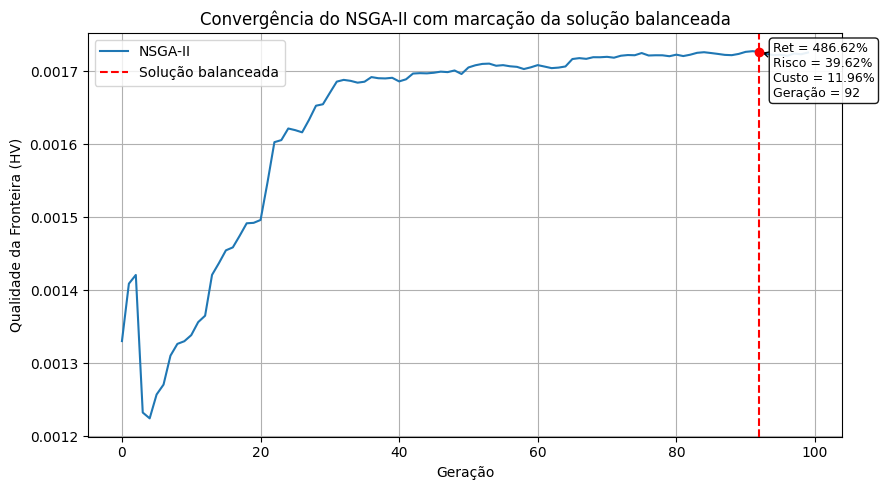

In [53]:
# -----------------------------
# Calcular HV por gera√ß√£o
# -----------------------------

all_F = np.vstack([gen.pop.get("F") for gen in res_nsga2.history])
ref_point = np.max(all_F, axis=0) * 1.1  # ponto de refer√™ncia 10% acima do pior valor em cada objetivo

hv = HV(ref_point=ref_point)
hv_values = []

for algo_gen in res_nsga2.history:
    F = algo_gen.pop.get("F")
    hv_values.append(hv.do(F))

# -----------------------------
# Encontrar solu√ß√£o mais balanceada (m√≠nima soma de ranks)
# -----------------------------

pareto_objectives = res_nsga2.F  # [ -retorno, risco, custo ]

# Rank normalizado para cada objetivo
rankings = np.argsort(np.argsort(pareto_objectives, axis=0), axis=0)
rank_sums = np.sum(rankings, axis=1)
melhor_idx = np.argmin(rank_sums)

melhor_obj = pareto_objectives[melhor_idx]

# Localizar em qual gera√ß√£o essa solu√ß√£o apareceu
geracao_melhor_balanceada = None
for gen_idx, gen in enumerate(res_nsga2.history):
    F_gen = gen.pop.get("F")
    for f in F_gen:
        if np.allclose(f, melhor_obj):
            geracao_melhor_balanceada = gen_idx
            break
    if geracao_melhor_balanceada is not None:
        break

# -----------------------------
# Plotar gr√°fico final
# -----------------------------

plt.figure(figsize=(9, 5))
plt.plot(np.arange(len(hv_values)), hv_values, label='NSGA-II')

# Marcar apenas a gera√ß√£o da solu√ß√£o balanceada
if geracao_melhor_balanceada is not None:
    plt.axvline(x=geracao_melhor_balanceada, color='red', linestyle='--', label='Solu√ß√£o balanceada')
    plt.scatter(geracao_melhor_balanceada, hv_values[geracao_melhor_balanceada], color='red', zorder=5)

    # Ponto de anota√ß√£o (canto superior direito)
    x_text = plt.xlim()[1] - 10
    y_text = plt.ylim()[1] * 0.95

    # Adicionar anota√ß√£o com seta
    plt.annotate(
        f'Ret = {-melhor_obj[0] * 10000000:.2f}%\nRisco = {melhor_obj[1] * 100000:.2f}%\nCusto = {melhor_obj[2] * 10000000:.2f}%\nGera√ß√£o = {geracao_melhor_balanceada}',
        xy=(geracao_melhor_balanceada, hv_values[geracao_melhor_balanceada]),  # ponto da seta
        xytext=(x_text, y_text),  # posi√ß√£o do texto
        arrowprops=dict(arrowstyle='->'),
        fontsize=9,
        bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.9)
    )

# T√≠tulo e legendas
plt.title("Converg√™ncia do NSGA-II com marca√ß√£o da solu√ß√£o balanceada")
plt.xlabel("Gera√ß√£o")
plt.ylabel("Qualidade da Fronteira (HV)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Nesta etapa, foi realizada uma segunda otimiza√ß√£o multiobjetivo, desta vez utilizando o algoritmo NSGA-III (Non-dominated Sorting Genetic Algorithm III), que √© especialmente adequado para problemas com mais de dois objetivos. A otimiza√ß√£o foi conduzida com os mesmos tr√™s objetivos anteriores: maximiza√ß√£o do retorno, minimiza√ß√£o do risco e minimiza√ß√£o do custo de rebalanceamento da carteira.

O primeiro passo consistiu na gera√ß√£o das dire√ß√µes de refer√™ncia por meio do m√©todo ‚Äúdas-dennis‚Äù, que distribui uniformemente vetores em um espa√ßo tridimensional (tr√™s objetivos). Essas dire√ß√µes servem como guias para manter a diversidade das solu√ß√µes ao longo da execu√ß√£o do algoritmo. Foram especificadas 12 parti√ß√µes, o que resulta em um conjunto de dire√ß√µes de refer√™ncia suficiente para cobrir bem o espa√ßo objetivo.

Em seguida, foi configurado o algoritmo NSGA3 da biblioteca pymoo, com popula√ß√£o de 100 indiv√≠duos, amostragem cont√≠nua aleat√≥ria (FloatRandomSampling()), crossover do tipo SBX (Simulated Binary Crossover) com alta probabilidade de recombina√ß√£o (90%) e muta√ß√£o polinomial (PM) com par√¢metro eta de 20, que controla a intensidade da muta√ß√£o. A op√ß√£o eliminate_duplicates=True assegura que solu√ß√µes repetidas sejam descartadas, preservando a diversidade da popula√ß√£o.

A otimiza√ß√£o foi executada com o m√©todo minimize, usando os mesmos crit√©rios de termina√ß√£o utilizados anteriormente (n√£o mostrados, mas presumivelmente baseados em n√∫mero de gera√ß√µes ou converg√™ncia). O hist√≥rico completo de todas as gera√ß√µes tamb√©m foi salvo para permitir an√°lises posteriores.

O NSGA-III, diferentemente do NSGA-II, busca distribuir as solu√ß√µes ao longo das dire√ß√µes de refer√™ncia definidas, o que torna o algoritmo particularmente eficaz na manuten√ß√£o de uma boa cobertura e diversidade da fronteira de Pareto em problemas com tr√™s ou mais objetivos. Esse tipo de abordagem √© √∫til para cen√°rios em que se deseja visualizar uma ampla gama de solu√ß√µes otimizadas, permitindo ao tomador de decis√£o escolher entre diferentes trade-offs.

In [54]:
# -------------------------------------
# NSGA-III
# -------------------------------------
ref_dirs_nsga3 = get_reference_directions("das-dennis", 3, n_partitions=12)
algorithm_nsga3 = NSGA3(
    ref_dirs=ref_dirs_nsga3,
    pop_size=100,
    sampling=FloatRandomSampling(),
    crossover=SBX(prob=0.9, eta=15),
    mutation=PM(eta=20),
    eliminate_duplicates=True
)

res_nsga3 = minimize(problem,
                     algorithm_nsga3,
                     termination,
                     seed=1,
                     save_history=True,
                     verbose=False)

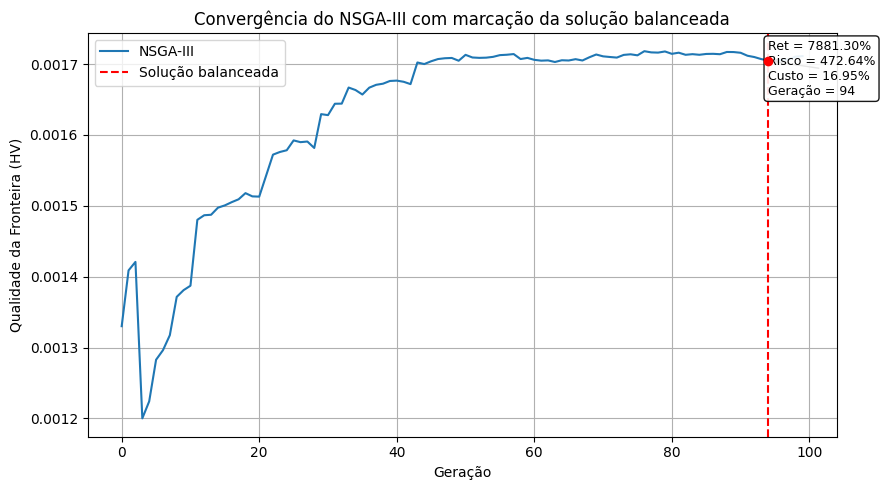

In [55]:
# -----------------------------
# Calcular HV por gera√ß√£o - NSGA-III
# -----------------------------

all_F = np.vstack([gen.pop.get("F") for gen in res_nsga3.history])
ref_point = np.max(all_F, axis=0) * 1.1  # ponto de refer√™ncia 10% acima do pior valor em cada objetivo

hv = HV(ref_point=ref_point)
hv_values = []

for algo_gen in res_nsga3.history:
    F = algo_gen.pop.get("F")
    hv_values.append(hv.do(F))

# -----------------------------
# Encontrar solu√ß√£o mais balanceada (m√≠nima soma de ranks)
# -----------------------------

pareto_objectives = res_nsga3.F  # [ -retorno, risco, custo ]

# Rank normalizado para cada objetivo
rankings = np.argsort(np.argsort(pareto_objectives, axis=0), axis=0)
rank_sums = np.sum(rankings, axis=1)
melhor_idx = np.argmin(rank_sums)

melhor_obj = pareto_objectives[melhor_idx]

# Localizar em qual gera√ß√£o essa solu√ß√£o apareceu
geracao_melhor_balanceada = None
for gen_idx, gen in enumerate(res_nsga3.history):
    F_gen = gen.pop.get("F")
    for f in F_gen:
        if np.allclose(f, melhor_obj):
            geracao_melhor_balanceada = gen_idx
            break
    if geracao_melhor_balanceada is not None:
        break

# -----------------------------
# Plotar gr√°fico final
# -----------------------------

plt.figure(figsize=(9, 5))
plt.plot(np.arange(len(hv_values)), hv_values, label='NSGA-III')

# Marcar apenas a gera√ß√£o da solu√ß√£o balanceada
if geracao_melhor_balanceada is not None:
    plt.axvline(x=geracao_melhor_balanceada, color='red', linestyle='--', label='Solu√ß√£o balanceada')
    plt.scatter(geracao_melhor_balanceada, hv_values[geracao_melhor_balanceada], color='red', zorder=5)

    # Ponto de anota√ß√£o (canto superior direito)
    x_text = plt.xlim()[1] - 10
    y_text = plt.ylim()[1] * 0.95

    # Adicionar anota√ß√£o com seta
    plt.annotate(
        f'Ret = {-melhor_obj[0] * 10000000:.2f}%\nRisco = {melhor_obj[1] * 100000:.2f}%\nCusto = {melhor_obj[2] * 10000000:.2f}%\nGera√ß√£o = {geracao_melhor_balanceada}',
        xy=(geracao_melhor_balanceada, hv_values[geracao_melhor_balanceada]),  # ponto da seta
        xytext=(x_text, y_text),  # posi√ß√£o do texto
        arrowprops=dict(arrowstyle='->'),
        fontsize=9,
        bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.9)
    )

# T√≠tulo e legendas
plt.title("Converg√™ncia do NSGA-III com marca√ß√£o da solu√ß√£o balanceada")
plt.xlabel("Gera√ß√£o")
plt.ylabel("Qualidade da Fronteira (HV)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Nesta etapa, foi utilizada uma varia√ß√£o do algoritmo gen√©tico NSGA-II chamada R-NSGA-II (Reference-point based NSGA-II), que incorpora um ponto de aspira√ß√£o para guiar a busca evolutiva em dire√ß√£o a regi√µes preferenciais do espa√ßo de solu√ß√µes. Essa abordagem √© √∫til quando h√° um interesse expl√≠cito em priorizar certas caracter√≠sticas na solu√ß√£o √≥tima, como, por exemplo, um alto retorno com risco e custo controlados.

Foi definido um ponto de aspira√ß√£o fict√≠cio com os valores [[0.1], [-0.9], [0.05]], que representa, respectivamente, os valores-alvo desejados (ou toler√°veis) para retorno, risco e custo. Vale lembrar que, como o problema est√° formulado para minimiza√ß√£o (inclusive do retorno, que √© invertido com sinal negativo), os sinais desse vetor devem estar coerentes com essa l√≥gica.

O algoritmo RNSGA2 foi configurado com uma popula√ß√£o de 100 indiv√≠duos, epsilon de 0.01 (definindo a sensibilidade em torno do ponto de aspira√ß√£o), amostragem aleat√≥ria cont√≠nua (FloatRandomSampling()), crossover SBX (com alta taxa de recombina√ß√£o de 90%) e muta√ß√£o polinomial (PM) com par√¢metro eta de 20, al√©m de elimina√ß√£o de duplicatas.

A otimiza√ß√£o foi executada com o m√©todo minimize, utilizando o problema previamente definido com os tr√™s objetivos (retorno, risco e custo) e o mesmo crit√©rio de termina√ß√£o das abordagens anteriores. O hist√≥rico completo da execu√ß√£o foi salvo para an√°lises posteriores.

Diferentemente do NSGA-II e NSGA-III, o R-NSGA-II prioriza as solu√ß√µes que est√£o mais pr√≥ximas do ponto de aspira√ß√£o, sendo ideal quando se deseja convergir rapidamente para uma regi√£o espec√≠fica do conjunto de Pareto. Isso √© especialmente relevante em aplica√ß√µes financeiras, onde o decisor pode ter prefer√™ncias claras quanto ao n√≠vel de retorno e risco desejado.

In [56]:
# -------------------------------------
# R-NSGA-II
# -------------------------------------
ref_points = np.array([[0.1], [-0.9], [0.05]]) # ponto de aspira√ß√£o fict√≠cio, pode ajustar
algorithm_rnsga2 = RNSGA2(
    ref_points=ref_points,
    pop_size=100,
    epsilon=0.01,
    sampling=FloatRandomSampling(),
    crossover=SBX(prob=0.9, eta=15),
    mutation=PM(eta=20),
    eliminate_duplicates=True
)

res_rnsga2 = minimize(problem,
                      algorithm_rnsga2,
                      termination,
                      seed=1,
                      save_history=True,
                      verbose=False)

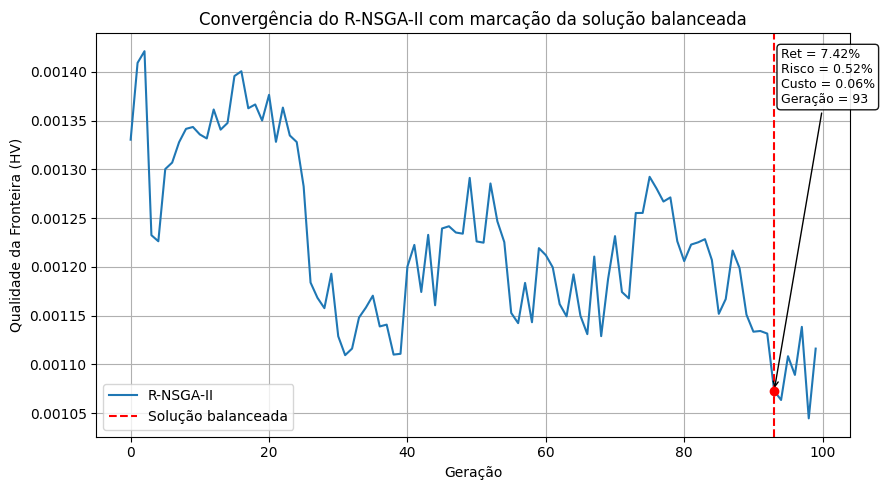

In [57]:
# -----------------------------
# Calcular HV por gera√ß√£o - R-NSGA-II
# -----------------------------

all_F = np.vstack([gen.pop.get("F") for gen in res_rnsga2.history])
ref_point = np.max(all_F, axis=0) * 1.1  # ponto de refer√™ncia 10% acima do pior valor em cada objetivo

hv = HV(ref_point=ref_point)
hv_values = []

for algo_gen in res_rnsga2.history:
    F = algo_gen.pop.get("F")
    hv_values.append(hv.do(F))

# -----------------------------
# Encontrar solu√ß√£o mais balanceada (m√≠nima soma de ranks)
# -----------------------------

pareto_objectives = res_rnsga2.F  # [ -retorno, risco, custo ]

# Rank normalizado para cada objetivo
rankings = np.argsort(np.argsort(pareto_objectives, axis=0), axis=0)
rank_sums = np.sum(rankings, axis=1)
melhor_idx = np.argmin(rank_sums)

melhor_obj = pareto_objectives[melhor_idx]

# Localizar em qual gera√ß√£o essa solu√ß√£o apareceu
geracao_melhor_balanceada = None
for gen_idx, gen in enumerate(res_rnsga2.history):
    F_gen = gen.pop.get("F")
    for f in F_gen:
        if np.allclose(f, melhor_obj):
            geracao_melhor_balanceada = gen_idx
            break
    if geracao_melhor_balanceada is not None:
        break

# -----------------------------
# Plotar gr√°fico final
# -----------------------------

plt.figure(figsize=(9, 5))
plt.plot(np.arange(len(hv_values)), hv_values, label='R-NSGA-II')

# Marcar apenas a gera√ß√£o da solu√ß√£o balanceada
if geracao_melhor_balanceada is not None:
    plt.axvline(x=geracao_melhor_balanceada, color='red', linestyle='--', label='Solu√ß√£o balanceada')
    plt.scatter(geracao_melhor_balanceada, hv_values[geracao_melhor_balanceada], color='red', zorder=5)

    # Ponto de anota√ß√£o (canto superior direito)
    x_text = plt.xlim()[1] - 10
    y_text = plt.ylim()[1] * 0.95

    # Adicionar anota√ß√£o com seta
    plt.annotate(
        f'Ret = {-melhor_obj[0] * 10000000:.2f}%\nRisco = {melhor_obj[1] * 100000:.2f}%\nCusto = {melhor_obj[2] * 10000000:.2f}%\nGera√ß√£o = {geracao_melhor_balanceada}',
        xy=(geracao_melhor_balanceada, hv_values[geracao_melhor_balanceada]),  # ponto da seta
        xytext=(x_text, y_text),  # posi√ß√£o do texto
        arrowprops=dict(arrowstyle='->'),
        fontsize=9,
        bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.9)
    )

# T√≠tulo e legendas
plt.title("Converg√™ncia do R-NSGA-II com marca√ß√£o da solu√ß√£o balanceada")
plt.xlabel("Gera√ß√£o")
plt.ylabel("Qualidade da Fronteira (HV)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Nesta etapa final do processo, foi realizado o plot da fronteira de Pareto em tr√™s dimens√µes para comparar visualmente os resultados obtidos pelos tr√™s algoritmos utilizados: NSGA-II, NSGA-III e R-NSGA-II. Cada subgr√°fico apresenta uma nuvem de pontos representando as solu√ß√µes n√£o-dominadas encontradas por cada algoritmo no espa√ßo dos tr√™s objetivos: retorno, risco e custo.

Como o retorno foi modelado para ser minimizado durante o processo de otimiza√ß√£o (ou seja, convertido em negativo), ele foi invertido no momento da visualiza√ß√£o (-res.F[:, 0]) para que os gr√°ficos reflitam corretamente a l√≥gica intuitiva de que maior retorno √© melhor.

Esse tipo de visualiza√ß√£o √© essencial para comparar a distribui√ß√£o e a qualidade das solu√ß√µes encontradas, identificando por exemplo quais algoritmos tendem a explorar melhor certas regi√µes da fronteira de Pareto, ou quais apresentam maior diversidade e cobertura em rela√ß√£o aos objetivos.

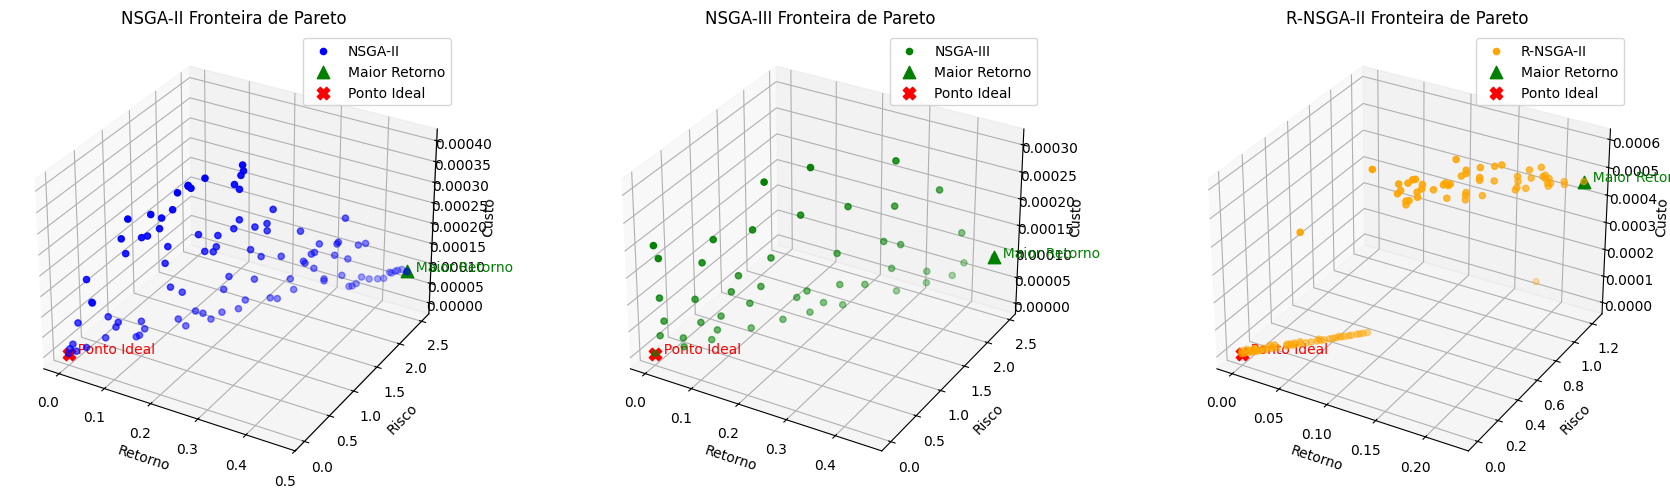

In [58]:
# -----------------------------
# 6. PLOTAR FRONTEIRA DE PARETO
# -----------------------------

def marcar_pontos(ax, F):
    retorno = -F[:, 0]  # Inverte para maximizar
    risco = F[:, 1]
    custo = F[:, 2]

    # Ponto com maior retorno
    idx_max_ret = np.argmax(retorno)
    ponto_max_ret = (retorno[idx_max_ret], risco[idx_max_ret], custo[idx_max_ret])
    ax.scatter(*ponto_max_ret, c='green', s=80, marker='^', label='Maior Retorno')
    ax.text(*ponto_max_ret, '  Maior Retorno', color='green')

    # Ponto ideal: maior retorno, menor risco e menor custo
    idx_ideal = np.argmax(retorno - risco - custo)
    ponto_ideal = (retorno[idx_ideal], risco[idx_ideal], custo[idx_ideal])
    ax.scatter(*ponto_ideal, c='red', s=80, marker='X', label='Ponto Ideal')
    ax.text(*ponto_ideal, '  Ponto Ideal', color='red')

# -----------------------------
# 6. PLOTAR FRONTEIRA DE PARETO
# -----------------------------
fig = plt.figure(figsize=(18, 5))

# NSGA-II
ax1 = fig.add_subplot(131, projection='3d')
retorno_nsga2 = -res_nsga2.F[:, 0]
ax1.scatter(retorno_nsga2, res_nsga2.F[:, 1], res_nsga2.F[:, 2], c='blue', label='NSGA-II')
ax1.set_title('NSGA-II Fronteira de Pareto')
ax1.set_xlabel('Retorno')
ax1.set_ylabel('Risco')
ax1.set_zlabel('Custo')
marcar_pontos(ax1, res_nsga2.F)
ax1.legend()

# NSGA-III
ax2 = fig.add_subplot(132, projection='3d')
retorno_nsga3 = -res_nsga3.F[:, 0]
ax2.scatter(retorno_nsga3, res_nsga3.F[:, 1], res_nsga3.F[:, 2], c='green', label='NSGA-III')
ax2.set_title('NSGA-III Fronteira de Pareto')
ax2.set_xlabel('Retorno')
ax2.set_ylabel('Risco')
ax2.set_zlabel('Custo')
marcar_pontos(ax2, res_nsga3.F)
ax2.legend()

# R-NSGA-II
ax3 = fig.add_subplot(133, projection='3d')
retorno_rnsga2 = -res_rnsga2.F[:, 0]
ax3.scatter(retorno_rnsga2, res_rnsga2.F[:, 1], res_rnsga2.F[:, 2], c='orange', label='R-NSGA-II')
ax3.set_title('R-NSGA-II Fronteira de Pareto')
ax3.set_xlabel('Retorno')
ax3.set_ylabel('Risco')
ax3.set_zlabel('Custo')
marcar_pontos(ax3, res_rnsga2.F)
ax3.legend()

plt.tight_layout()
plt.show()